In [1]:
from __future__ import print_function
import os
import pickle

from zipfile import ZipFile
import xml.sax, xml.sax.handler

from netCDF4 import Dataset

import boto3
import botocore
import xarray as xr
era5_bucket = 'era5-pds'
client = boto3.client('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED))

here = os.path.dirname(os.path.abspath('/media/synology2/WANDS/ERA5/'))

import numpy as np
import time
import datetime

from sklearn import svm, datasets
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

import scipy.io
import scipy.integrate
from astropy.convolution import convolve, Box1DKernel
from spacepy import pycdf

from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc
from matplotlib.colors import LogNorm
from matplotlib.patches import Polygon
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.path import Path as mpath
from matplotlib.collections import PatchCollection

import pandas as pd
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.options.display.max_columns = 999
pd.options.display.max_rows = 90

np.set_printoptions(threshold=np.nan)

plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
plt.rc('text', usetex=True)

###############
## COMPUTER ##
###############

laptop = False

In [3]:
###############
## AIR TEMP PULL ##
###############

%cd /media/synology2/WANDS/ERA5/

years = range(2008,2017+1)
months = range(1,12+1)

for i in years:
    for j in months:
        # select date and variable of interest
        date = datetime.date(i,j,1)
        var = 'air_temperature_at_2_metres'

        # file path patterns for remote S3 objects and corresponding local file
        s3_data_ptrn = '{year}/{month}/data/{var}.nc'
        data_file_ptrn = '{year}{month}_{var}.nc'

        year = date.strftime('%Y')
        month = date.strftime('%m')
        s3_data_key = s3_data_ptrn.format(year=year, month=month, var=var)
        data_file = data_file_ptrn.format(year=year, month=month, var=var)

        if not os.path.isfile(data_file): # check if file already exists
            print("Downloading %s from S3..." % s3_data_key)
            client.download_file(era5_bucket, s3_data_key, data_file)

/media/synology2/WANDS/ERA5


In [4]:
###############
## NORTH WIND PULL ##
###############

%cd /media/synology2/WANDS/ERA5/

years = range(2008,2017+1)
months = range(1,12+1)

for i in years:
    for j in months:
        # select date and variable of interest
        date = datetime.date(i,j,1)
        var = 'northward_wind_at_10_metres'

        # file path patterns for remote S3 objects and corresponding local file
        s3_data_ptrn = '{year}/{month}/data/{var}.nc'
        data_file_ptrn = '{year}{month}_{var}.nc'

        year = date.strftime('%Y')
        month = date.strftime('%m')
        s3_data_key = s3_data_ptrn.format(year=year, month=month, var=var)
        data_file = data_file_ptrn.format(year=year, month=month, var=var)

        if not os.path.isfile(data_file): # check if file already exists
            print("Downloading %s from S3..." % s3_data_key)
            client.download_file(era5_bucket, s3_data_key, data_file)

/media/synology2/WANDS/ERA5


In [5]:
###############
## EAST WIND PULL ##
###############

%cd /media/synology2/WANDS/ERA5/

years = range(2008,2017+1)
months = range(1,12+1)

for i in years:
    for j in months:
        # select date and variable of interest
        date = datetime.date(i,j,1)
        var = 'eastward_wind_at_10_metres'

        # file path patterns for remote S3 objects and corresponding local file
        s3_data_ptrn = '{year}/{month}/data/{var}.nc'
        data_file_ptrn = '{year}{month}_{var}.nc'

        year = date.strftime('%Y')
        month = date.strftime('%m')
        s3_data_key = s3_data_ptrn.format(year=year, month=month, var=var)
        data_file = data_file_ptrn.format(year=year, month=month, var=var)

        if not os.path.isfile(data_file): # check if file already exists
            print("Downloading %s from S3..." % s3_data_key)
            client.download_file(era5_bucket, s3_data_key, data_file)

/media/synology2/WANDS/ERA5


In [6]:
###############
## DEW POINT PULL ##
###############

%cd /media/synology2/WANDS/ERA5/

years = range(2008,2017+1)
months = range(1,12+1)

for i in years:
    for j in months:
        # select date and variable of interest
        date = datetime.date(i,j,1)
        var = 'dew_point_temperature_at_2_metres'

        # file path patterns for remote S3 objects and corresponding local file
        s3_data_ptrn = '{year}/{month}/data/{var}.nc'
        data_file_ptrn = '{year}{month}_{var}.nc'

        year = date.strftime('%Y')
        month = date.strftime('%m')
        s3_data_key = s3_data_ptrn.format(year=year, month=month, var=var)
        data_file = data_file_ptrn.format(year=year, month=month, var=var)

        if not os.path.isfile(data_file): # check if file already exists
            print("Downloading %s from S3..." % s3_data_key)
            client.download_file(era5_bucket, s3_data_key, data_file)

/media/synology2/WANDS/ERA5


In [17]:
paginator = client.get_paginator('list_objects')
result = paginator.paginate(Bucket=era5_bucket, Prefix='2008/01/data/', Delimiter='/')
for prefix in result.search('CommonPrefixes'):
    print(prefix.get('Prefix'))

AttributeError: 'NoneType' object has no attribute 'get'

In [20]:
from botocore.handlers import disable_signing
resource = boto3.resource('s3')
resource.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
my_bucket = resource.Bucket(era5_bucket)

for object in my_bucket.objects.filter(Prefix='2008/01/data/'):                
            print(object.key)

2008/01/data/air_pressure_at_mean_sea_level.nc
2008/01/data/air_temperature_at_2_metres.nc
2008/01/data/air_temperature_at_2_metres_1hour_Maximum.nc
2008/01/data/air_temperature_at_2_metres_1hour_Minimum.nc
2008/01/data/dew_point_temperature_at_2_metres.nc
2008/01/data/eastward_wind_at_100_metres.nc
2008/01/data/eastward_wind_at_10_metres.nc
2008/01/data/integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation.nc
2008/01/data/lwe_thickness_of_surface_snow_amount.nc
2008/01/data/northward_wind_at_100_metres.nc
2008/01/data/northward_wind_at_10_metres.nc
2008/01/data/precipitation_amount_1hour_Accumulation.nc
2008/01/data/sea_surface_temperature.nc
2008/01/data/snow_density.nc
2008/01/data/surface_air_pressure.nc


In [21]:
# select date and variable of interest
date = datetime.date(2008,1,1)
var = 'sea_surface_temperature'

# file path patterns for remote S3 objects and corresponding local file
s3_data_ptrn = '{year}/{month}/data/{var}.nc'
data_file_ptrn = '{year}{month}_{var}.nc'

year = date.strftime('%Y')
month = date.strftime('%m')
s3_data_key = s3_data_ptrn.format(year=year, month=month, var=var)
data_file = data_file_ptrn.format(year=year, month=month, var=var)

if not os.path.isfile(data_file): # check if file already exists
    print("Downloading %s from S3..." % s3_data_key)
    client.download_file(era5_bucket, s3_data_key, data_file)

ds = xr.open_dataset(data_file)
ds.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:                  (lat: 640, lon: 1280, time0: 744)
Coordinates:
  * lon                      (lon) float32 0.0 0.2812494 ... 359.43674 359.718
  * lat                      (lat) float32 89.784874 89.5062 ... -89.784874
  * time0                    (time0) datetime64[ns] 2008-01-01T07:00:00 ... 2008-02-01T06:00:00
Data variables:
    sea_surface_temperature  (time0, lat, lon) float32 ...
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    title:        "ERA5 forecasts"
    history:      Wed Jul  4 22:13:55 2018: ncatted /data.e1/wrk/s3_out_in/20...>

In [23]:
timestep = 5

ds = xr.open_dataset('200801_sea_surface_temperature.nc')
T = np.asarray(ds.sea_surface_temperature[timestep,:,:])

lat = np.asarray(ds.lat)
lon = np.asarray(ds.lon)
t = np.asarray(ds.time0[timestep])

LAT,LON = np.meshgrid(lat,lon)

In [40]:
ds.time0

<xarray.DataArray 'time0' (time0: 744)>
array(['2008-01-01T07:00:00.000000000', '2008-01-01T08:00:00.000000000',
       '2008-01-01T09:00:00.000000000', ..., '2008-02-01T04:00:00.000000000',
       '2008-02-01T05:00:00.000000000', '2008-02-01T06:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time0    (time0) datetime64[ns] 2008-01-01T07:00:00 ... 2008-02-01T06:00:00
Attributes:
    standard_name:  time

In [35]:
T[T==273.1604].shape

(272192,)

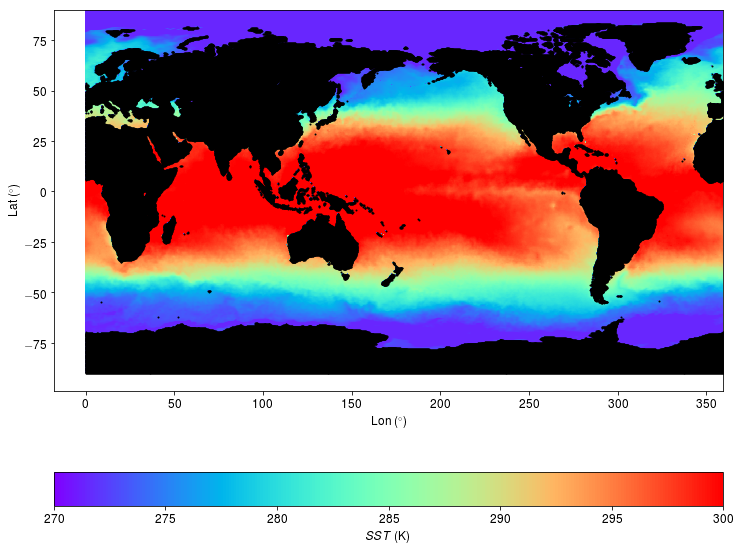

In [45]:
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

S = 1
LW = 0.8
fs = 12
SC = 100

v3 = 270
v4 = 300

lpu1 = 0
hpu1 = 25

fig = plt.gcf()

ax2 = plt.subplot(111)

sc1 = ax2.scatter(LON[T.T==273.1604], LAT[T.T==273.1604], c='k',s=S)
sc1 = ax2.pcolormesh(LON, LAT, T.T, cmap='rainbow',zorder=-1,vmin=v3,vmax=v4)

ax2.set_xlabel('Lon ($^{\\circ}$)', fontsize=fs)
ax2.set_ylabel('Lat ($^{\\circ}$)', fontsize=fs)
ax2.set_title('', loc='left', fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

cbar2 = fig.colorbar(sc1, ax=ax2, orientation='horizontal')
cbar2.ax.xaxis.set_ticks_position('bottom')
cbar2.set_label('$SST$ (K)',fontsize=fs)
cbar2.ax.xaxis.set_label_position('bottom')
cbar2.ax.tick_params(labelsize=fs)

fig.set_size_inches(12, 10, forward=True)
# %cd /home/andrew/Documents/
# plt.savefig('some_name79.png', bbox_inches='tight',dpi=300)